### __Name: Ishita Mehta__

### Task 7
- Create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and
sentimental analysis of news headlines.
- Stock to analyze and predict - SENSEX (S&P BSE SENSEX)
- Historical stock prices downloaded from finance.yahoo.com
- Textual (news) data: https://bit.ly/36fFPI6

### Import the Libraries

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import unicodedata
import nltk
import re
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost
import lightgbm

plt.rcdefaults()
plt.rcParams.update({'axes.facecolor':'white'})

In [74]:
pip install yfinance --upgrade --no-cache-dir

Requirement already up-to-date: yfinance in c:\users\mehta\anaconda3\lib\site-packages (0.1.63)
Note: you may need to restart the kernel to use updated packages.


### Get and explore the Data

In [3]:
## Reading historical stock prices from yahoo
import yfinance as yf
bse_df= yf.download('^BSESN', start='2015-01-01', end='2021-07-21')

[*********************100%***********************]  1 of 1 completed


In [4]:
bse_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400
2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,27842.320312,9200
2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100
2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,26908.820312,12200
2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200
...,...,...,...,...,...,...
2021-07-14,52801.441406,52978.578125,52611.968750,52904.050781,52904.050781,9300
2021-07-15,52968.890625,53266.121094,52948.429688,53158.851562,53158.851562,8100
2021-07-16,53244.398438,53290.808594,52997.089844,53140.058594,53140.058594,6700


In [5]:
## Reset the index
bse_df.reset_index(inplace=True)

In [6]:
bse_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1608 entries, 0 to 1607
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1608 non-null   datetime64[ns]
 1   Open       1608 non-null   float64       
 2   High       1608 non-null   float64       
 3   Low        1608 non-null   float64       
 4   Close      1608 non-null   float64       
 5   Adj Close  1608 non-null   float64       
 6   Volume     1608 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 88.1 KB


In [7]:
## To check for null values
bse_df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

There are no null values.

In [8]:
## Read news data from the csv file
news_df= pd.read_csv('india-news-headlines.csv')
news_df

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic
...,...,...,...
3424062,20201231,city.jodhpur,Covid-19: Despite dip in cases; Rajasthan amon...
3424063,20201231,city.udaipur,Covid-19: Despite dip in cases; Rajasthan amon...
3424064,20201231,city.ajmer,Covid-19: Despite dip in cases; Rajasthan amon...
3424065,20201231,removed,Govt extends deadline for use of FASTag till F...


In [9]:
## Drop category and rename the rest of the columns.
news_df.drop('headline_category', axis=1,inplace=True)
news_df.rename(columns={'publish_date':'Date','headline_text':'News'},inplace=True)
news_df

,Date,News
0,20010102,Status quo will not be disturbed at Ayodhya; s...
1,20010102,Fissures in Hurriyat over Pak visit
2,20010102,America's unwanted heading for India?
3,20010102,For bigwigs; it is destination Goa
4,20010102,Extra buses to clear tourist traffic
...,...,...
3424062,20201231,Covid-19: Despite dip in cases; Rajasthan amon...
3424063,20201231,Covid-19: Despite dip in cases; Rajasthan amon...
3424064,20201231,Covid-19: Despite dip in cases; Rajasthan amon...
3424065,20201231,Govt extends deadline for use of FASTag till F...


In [10]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424067 entries, 0 to 3424066
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Date    int64 
 1   News    object
dtypes: int64(1), object(1)
memory usage: 52.2+ MB


In [11]:
news_df.isnull().sum()

Date    0
News    0
dtype: int64

There are no null values.

In [12]:
## Convert Date to datetime format
news_df['Date']=pd.to_datetime(news_df['Date'], format='%Y%m%d')

In [13]:
## Group news by date
news_df['News'] = news_df.groupby(['Date']).transform(lambda x : ' '.join(x)) 
news_df=news_df.drop_duplicates()
news_df.reset_index(inplace = True, drop = True)
news_df

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-03,Powerless north India gropes in the dark Think...
2,2001-01-04,The string that pulled Stephen Hawking to Indi...
3,2001-01-05,Light combat craft takes India into club class...
4,2001-01-06,Light combat craft takes India into club class...
...,...,...
7257,2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
7258,2020-12-28,Horoscope Today; 28 December 2020: Check astro...
7259,2020-12-29,Man recovers charred remains of 'thief' from h...
7260,2020-12-30,Numerology Readings 30 December 2020: Predicti...


In [14]:
## Removing unwanted characters
news_df.replace("[^a-zA-Z']"," ",regex=True,inplace=True)

C:\Users\mehta\anaconda3\lib\site-packages\pandas\core\frame.py:4379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


__Historical Stock Prices Analysis :__

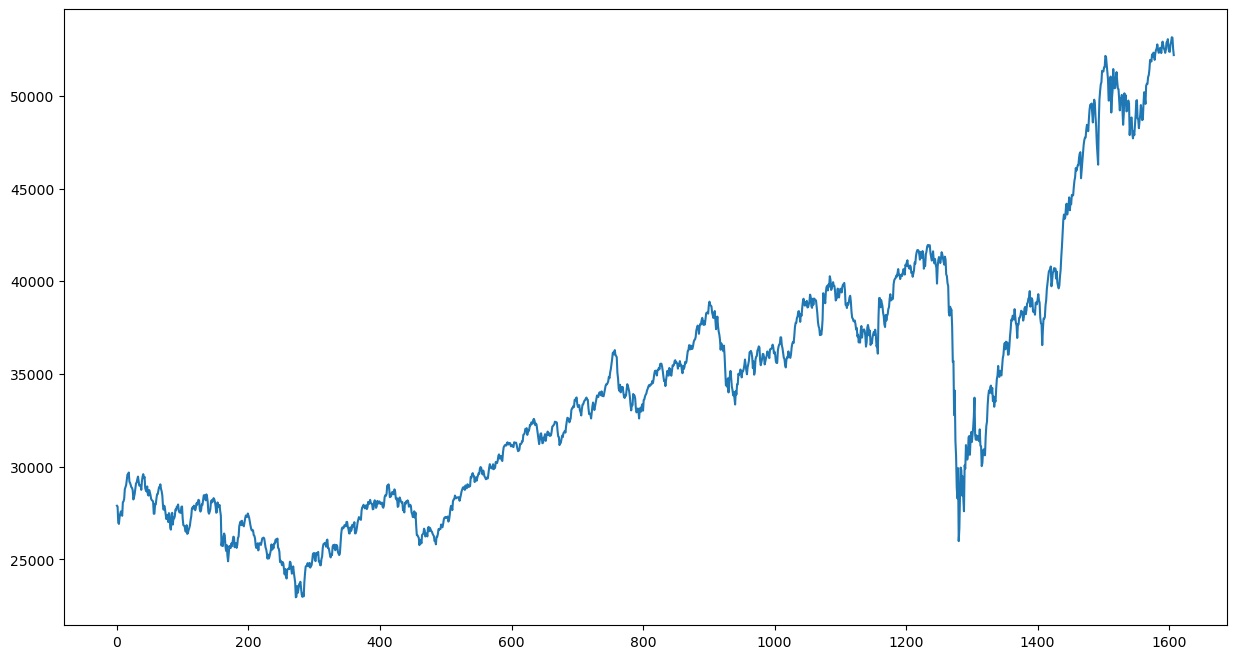

In [15]:
## Plot the closing stock prices
plt.figure(figsize=(15,8))
plt.plot(bse_df['Close'])

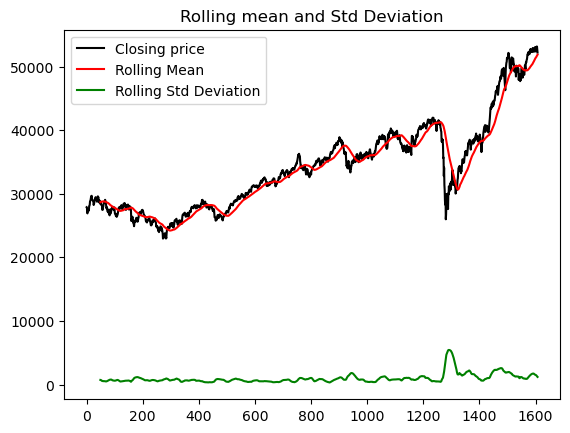

In [16]:
## Plottig the moving average
rmean= bse_df['Close'].rolling(window=50).mean()
rstd= bse_df['Close'].rolling(window=50).std()

bse_df['Close'].plot(color='black',label='Closing price')
rmean.plot(color='red',label='Rolling Mean')
rstd.plot(color='green',label='Rolling Std Deviation')
plt.title('Rolling mean and Std Deviation')
plt.legend()

Text(0.5, 1.0, 'Returns')

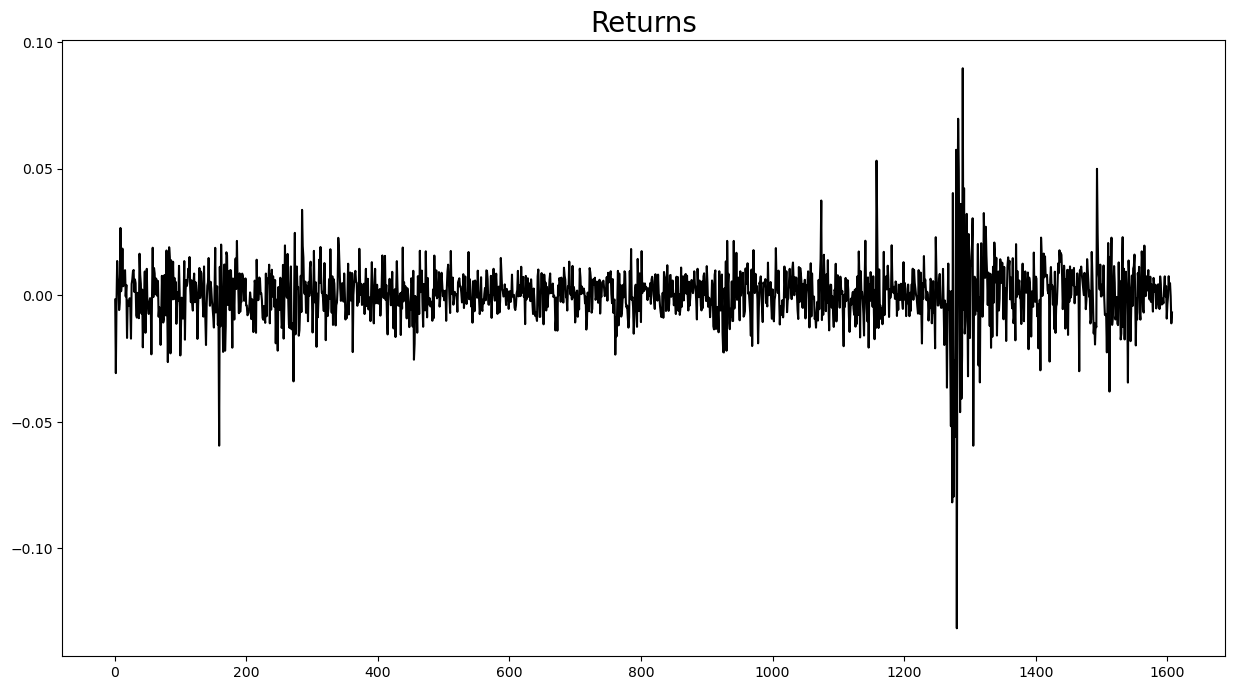

In [17]:
#Plotting returns
ret = bse_df['Close'] / bse_df['Close'].shift(1)-1
plt.figure(figsize=(15,8))
ret.plot(label='Returns',color = 'black')
plt.title("Returns", fontsize=20)

In [18]:
## Splitting the data
bse_df.shape

(1608, 7)

In [19]:
 ## Taking  train-test set ratio,
train=bse_df[:1400]
test=bse_df[1400:]

We want the timeseries to be stationary, i.e, its mean, variance, standard deviation should remain constant with time. <br>
To check this,we perform the Augumented Dickey Fuller (ADF) test for stationary timeseries.

Results of ADF test:
ADF Test Statistic : -1.3950133451458187
p-value : 0.5846644348622897
#Lags Used : 11
Number of Observations Used : 1388
Failed to reject the Null hypothesis, time series is non-stationary. 


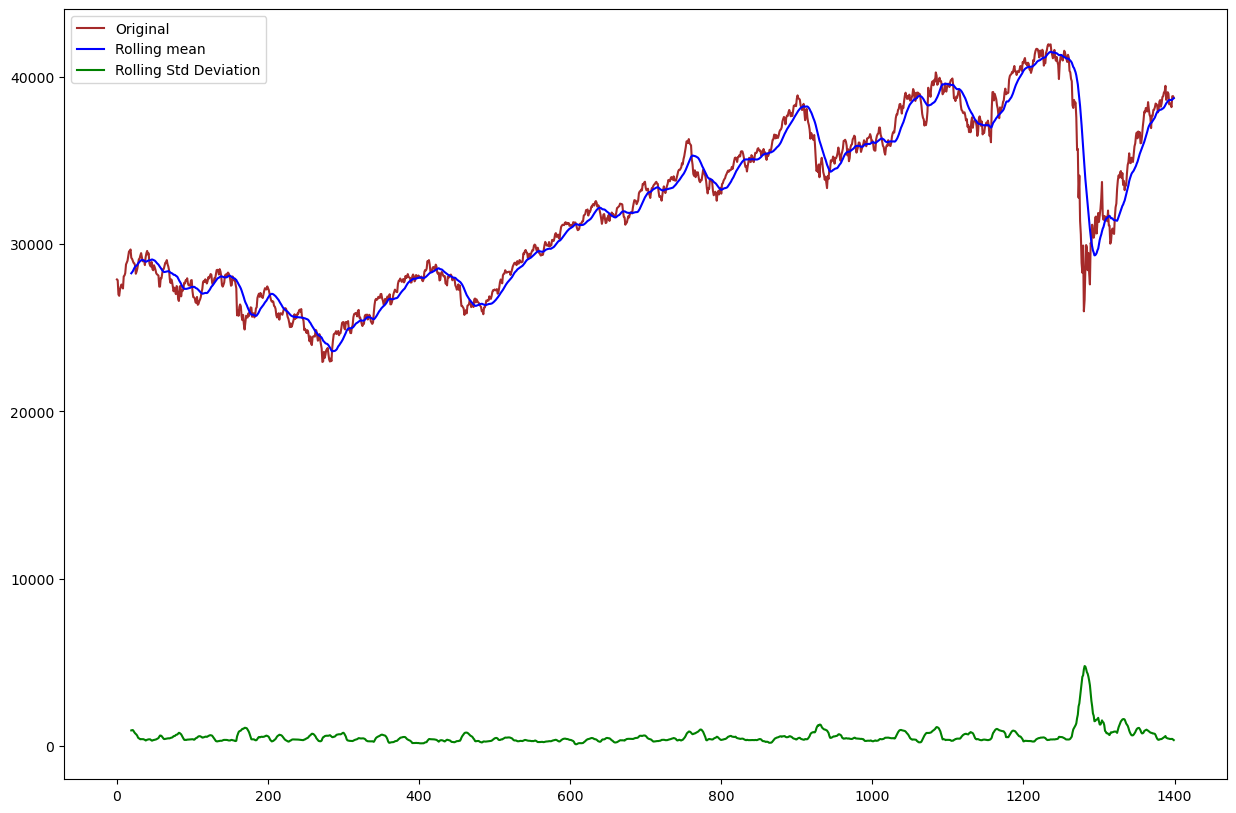

In [20]:
def ADF_test(timeseries):
    rmean=timeseries.rolling(window=20).mean()
    rstd=timeseries.rolling(window=20).std()
    
    plt.figure(figsize=(15,10))
    timeseries.plot(label='Original', color='brown')
    rmean.plot(label='Rolling mean', color='blue')
    rstd.plot(label='Rolling Std Deviation', color='green')
    plt.legend()
    
    print('Results of ADF test:')
    res = adfuller(timeseries, autolag = 'AIC')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(res, labels):
        print(label+' : '+str(value) )
    if res[1] <= 0.05:
        print("Null hypothesis (Ho) rejected , timeseries is stationary.")
    else:
        print("Failed to reject the Null hypothesis, time series is non-stationary. ")
ADF_test(train['Close'])

Since the p value turned out to be greater than 0.05, timeseries proved to be non-stationary, we now try log transormation to stabalise the variance and achieve a better result.

Results of ADF test:
ADF Test Statistic : -1.3219046227338445
p-value : 0.6190922988402833
#Lags Used : 11
Number of Observations Used : 1388
Failed to reject the Null hypothesis, time series is non-stationary. 


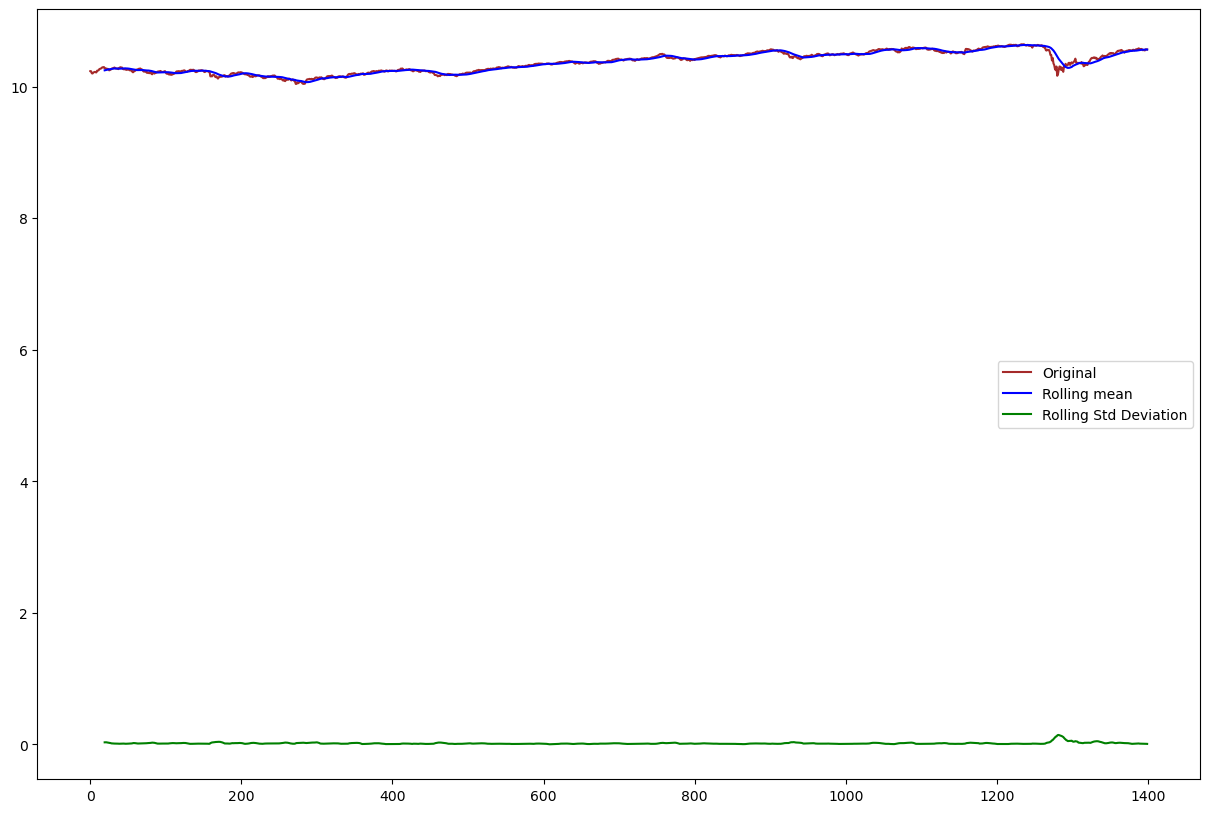

In [21]:
## log tranformation
ltrain = np.log(train['Close']) 
ltest = np.log(test['Close'])
ADF_test(ltrain)

Failed to reject the Null hypothesis again. Differencing is performed with the moving average.

Results of ADF test:
ADF Test Statistic : -7.796922244295836
p-value : 7.673757365780173e-12
#Lags Used : 12
Number of Observations Used : 1364
Null hypothesis (Ho) rejected , timeseries is stationary.


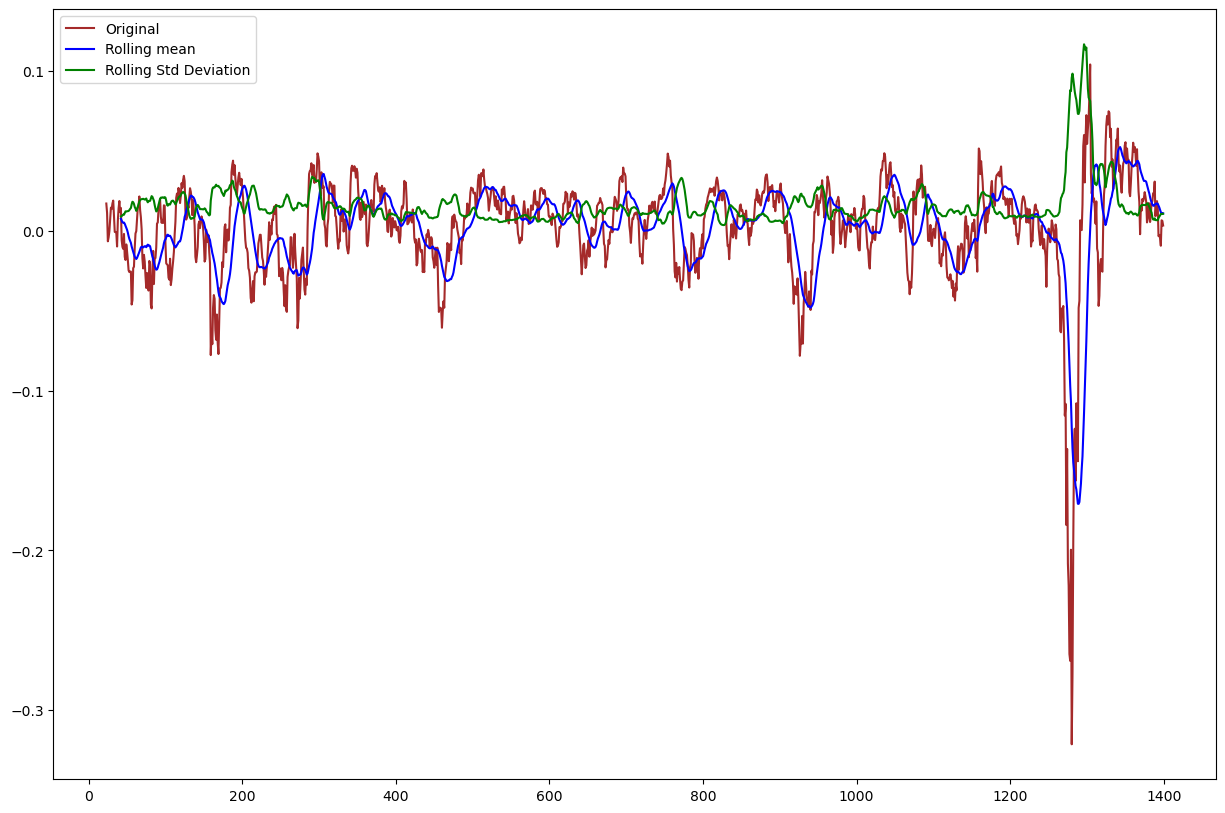

In [22]:
m_avg = ltrain.rolling(24).mean()
ltrain_diff= ltrain-m_avg
ltrain_diff.dropna(inplace=True)

ADF_test(ltrain_diff)

Null hypothesis rejected. Timeseries does not have a unit root, and is thus stationary.

### ARIMA Model

We use the Autoregressive Integrated Moving Average (ARIMA) model that aims to predict data in a timeseries. <br>
ARIMA performs integration on the timeseries i.e, converts non-stationary to a stationary one by differencing.

In [23]:
import pmdarima as pmd

In [24]:
model = pmd.auto_arima(ltrain, trace = True, error_action = 'ignore', suppress_warnings = True)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-8516.781, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8522.722, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8524.899, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8524.679, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8524.135, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-8523.731, Time=0.41 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8523.154, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-8521.806, Time=0.81 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-8526.244, Time=0.31 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-8525.111, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-8524.513, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-8526.003, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-8523.188, Time=0.33 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.765 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1400
Model:               SARIMAX(1, 1, 0)   Log Likelihood                4265.122
Date:                Thu, 22 Jul 2021   AIC                          -8526.244
Time:                        16:58:54   BIC                          -8515.757
Sample:                             0   HQIC                         -8522.324
                               - 1400                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0542      0.013     -4.083      0.000      -0.080      -0.028
sigma2         0.0001   1.66e-06     79.279      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             34573.07
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               2.53   Skew:                            -1.62
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Predictions

In [25]:
predictions = model.predict(len(ltest))
predictions = pd.DataFrame(predictions,index = ltest.index,columns=['Prediction'])

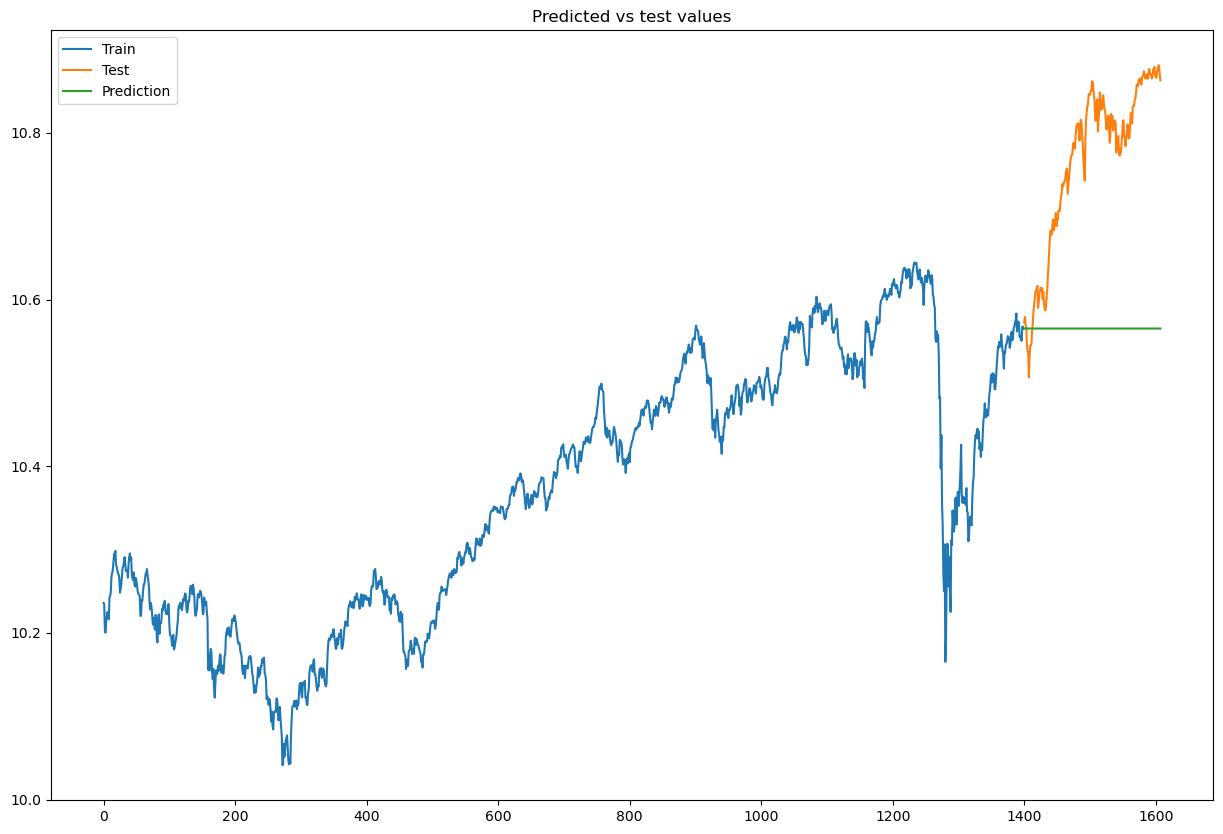

In [26]:
## Plot the predicted values.
plt.figure(figsize=(15,10))
plt.plot(ltrain, label='Train')
plt.plot(ltest, label='Test')
plt.plot(predictions, label='Prediction')
plt.title('Predicted vs test values')
plt.legend()

### Error evaluation

In [27]:
rmse = np.sqrt(mean_squared_error(ltest,predictions))
mae = mean_absolute_error(ltest,predictions)
print("RMSE : ", rmse)
print("Mean Absolute Error : ", mae)

RMSE :  0.22288621945337683
Mean Absolute Error :  0.20187987435735993


__News Headlines Analysis :__

Text blob and vader are the two libraries used here for sentiment analysis of news headlines.

In [28]:
## Adding Subjectivity and Polarity to news_df
news_df['Subjectivity']=news_df['News'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
news_df['Polarity']= news_df['News'].apply( lambda x: TextBlob(x).sentiment.polarity)
news_df

<ipython-input-28-8889aa5f4322>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_df['Subjectivity']=news_df['News'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
<ipython-input-28-8889aa5f4322>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_df['Polarity']= news_df['News'].apply( lambda x: TextBlob(x).sentiment.polarity)


,Date,News,Subjectivity,Polarity
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485
...,...,...,...,...
7257,2020-12-27,BigInterview Dhritiman Chatterjee Nobody da...,0.392082,0.042978
7258,2020-12-28,Horoscope Today December Check astro...,0.409973,0.071405
7259,2020-12-29,Man recovers charred remains of 'thief' from h...,0.415684,0.060775
7260,2020-12-30,Numerology Readings December Predicti...,0.436863,0.046930


In [29]:
## Adding sentiment score
sia = SentimentIntensityAnalyzer()

In [30]:
news_df['Compound']= [sia.polarity_scores(x)['compound'] for x in news_df['News']]
news_df['Positive']= [sia.polarity_scores(x)['pos'] for x in news_df['News']]
news_df['Negative']= [sia.polarity_scores(x)['neg'] for x in news_df['News']]
news_df['Neutral']= [sia.polarity_scores(x)['neu'] for x in news_df['News']]

<ipython-input-30-90d9d6a12647>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_df['Compound']= [sia.polarity_scores(x)['compound'] for x in news_df['News']]
<ipython-input-30-90d9d6a12647>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_df['Positive']= [sia.polarity_scores(x)['pos'] for x in news_df['News']]
<ipython-input-30-90d9d6a12647>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [33]:
news_df

,Date,News,Subjectivity,Polarity,Compound,Positive,Negative,Neutral
0,2001-01-02,Status quo will not be disturbed at Ayodhya s...,0.286859,0.143590,-0.9792,0.071,0.121,0.809
1,2001-01-03,Powerless north India gropes in the dark Think...,0.392857,0.089286,-0.8910,0.109,0.156,0.735
2,2001-01-04,The string that pulled Stephen Hawking to Indi...,0.445360,0.093039,0.7543,0.104,0.104,0.792
3,2001-01-05,Light combat craft takes India into club class...,0.480553,0.264024,0.9645,0.164,0.142,0.694
4,2001-01-06,Light combat craft takes India into club class...,0.439394,0.248485,-0.8316,0.131,0.214,0.655
...,...,...,...,...,...,...,...,...
7257,2020-12-27,BigInterview Dhritiman Chatterjee Nobody da...,0.392082,0.042978,-0.9997,0.082,0.132,0.787
7258,2020-12-28,Horoscope Today December Check astro...,0.409973,0.071405,-0.9998,0.098,0.143,0.758
7259,2020-12-29,Man recovers charred remains of 'thief' from h...,0.415684,0.060775,-0.9999,0.098,0.154,0.748
7260,2020-12-30,Numerology Readings December Predicti...,0.436863,0.046930,-0.9999,0.086,0.150,0.764


In [34]:
## Merging the datasets

In [35]:
df = pd.merge(bse_df, news_df, how='inner', on='Date')
df

,Date,Open,High,Low,Close,Adj Close,Volume,News,Subjectivity,Polarity,Compound,Positive,Negative,Neutral
0,2015-01-02,27521.279297,27937.470703,27519.259766,27887.900391,27887.900391,7400,Drink smart with these party tips How to say s...,0.454701,0.053671,-0.9997,0.117,0.149,0.733
1,2015-01-05,27978.429688,28064.490234,27786.849609,27842.320312,27842.320312,9200,Recipe Strawberry cupcakes Recipe Kaju jeera...,0.429367,0.100463,-0.9988,0.115,0.132,0.753
2,2015-01-06,27694.230469,27698.929688,26937.060547,26987.460938,26987.460938,14100,Turn to gardening for happiness Teeth jeweller...,0.388354,0.060982,-0.9997,0.082,0.120,0.798
3,2015-01-07,26983.429688,27051.599609,26776.119141,26908.820312,26908.820312,12200,Can ex lovers be friends Is water diet bad fo...,0.386384,0.033056,-1.0000,0.090,0.172,0.738
4,2015-01-08,27178.769531,27316.410156,27101.939453,27274.710938,27274.710938,8200,How to do a home manicure Recipe Spiced beetr...,0.406919,0.063963,-0.9999,0.084,0.146,0.770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1469,2020-12-24,46743.488281,47053.398438,46539.019531,46973.539062,46973.539062,13700,How to set the mood for sex during cold winter...,0.387011,0.053569,-0.9988,0.071,0.096,0.833
1470,2020-12-28,47153.589844,47406.718750,47148.238281,47353.750000,47353.750000,9600,Horoscope Today December Check astro...,0.409973,0.071405,-0.9998,0.098,0.143,0.758
1471,2020-12-29,47466.621094,47714.550781,47361.898438,47613.078125,47613.078125,12800,Man recovers charred remains of 'thief' from h...,0.415684,0.060775,-0.9999,0.098,0.154,0.748
1472,2020-12-30,47789.031250,47807.851562,47358.359375,47746.218750,47746.218750,15600,Numerology Readings December Predicti...,0.436863,0.046930,-0.9999,0.086,0.150,0.764


In [37]:
## Create new dataframe for model training.
df_new= df[['Subjectivity', 'Polarity', 'Compound', 'Positive', 'Negative', 'Neutral','Close']]
df_new

,Subjectivity,Polarity,Compound,Positive,Negative,Neutral,Close
0,0.454701,0.053671,-0.9997,0.117,0.149,0.733,27887.900391
1,0.429367,0.100463,-0.9988,0.115,0.132,0.753,27842.320312
2,0.388354,0.060982,-0.9997,0.082,0.120,0.798,26987.460938
3,0.386384,0.033056,-1.0000,0.090,0.172,0.738,26908.820312
4,0.406919,0.063963,-0.9999,0.084,0.146,0.770,27274.710938
...,...,...,...,...,...,...,...
1469,0.387011,0.053569,-0.9988,0.071,0.096,0.833,46973.539062
1470,0.409973,0.071405,-0.9998,0.098,0.143,0.758,47353.750000
1471,0.415684,0.060775,-0.9999,0.098,0.154,0.748,47613.078125
1472,0.436863,0.046930,-0.9999,0.086,0.150,0.764,47746.218750


In [39]:
## Data normalization
sc=MinMaxScaler()
scaled=pd.DataFrame(sc.fit_transform(df_new), columns=df_new.columns)
scaled

,Subjectivity,Polarity,Compound,Positive,Negative,Neutral,Close
0,0.876898,0.379204,0.00015,0.516667,0.464567,0.277419,0.199039
1,0.697712,0.650861,0.00060,0.500000,0.330709,0.406452,0.197201
2,0.407626,0.421651,0.00015,0.225000,0.236220,0.696774,0.162730
3,0.393689,0.259517,0.00000,0.291667,0.645669,0.309677,0.159559
4,0.538934,0.438955,0.00005,0.241667,0.440945,0.516129,0.174313
...,...,...,...,...,...,...,...
1469,0.398128,0.378608,0.00060,0.133333,0.047244,0.922581,0.968637
1470,0.560540,0.482161,0.00010,0.358333,0.417323,0.438710,0.983968
1471,0.600934,0.420444,0.00005,0.358333,0.503937,0.374194,0.994425
1472,0.750727,0.340068,0.00005,0.258333,0.472441,0.477419,0.999794


In [41]:
## Splitting dataframe into X and Y 
X= scaled.drop(['Close'], axis=1)
Y= scaled['Close']

In [44]:
## Train-test split
X_train, x_test, Y_train, y_test=train_test_split(X, Y, test_size=0.2, random_state = 0)

### Model Training 

In [78]:
def model_training(x):
    x.fit(X_train, Y_train)
    y_pred=x.predict(x_test)
    return y_pred

In [79]:
rf= RandomForestRegressor()
ans1= model_training(rf)

In [80]:
dt= DecisionTreeRegressor()
ans2= model_training(dt)

In [81]:
adboost= AdaBoostRegressor()
ans3= model_training(adboost)

In [82]:
gbm = lightgbm.LGBMRegressor()
ans4= model_training(gbm)

In [83]:
xgboost= xgboost.XGBRegressor()
ans5= model_training(xgboost)

### Error evaluation

In [87]:
print('MAE for Random Forest Regressor: ',mean_absolute_error(ans1,y_test))
print('MAE for Decision Tree Regressor: ',mean_absolute_error(ans2,y_test))
print('MAE for Ada Boost Regressor: ',mean_absolute_error(ans3,y_test))
print('MAE for LGBM Regressor: ',mean_absolute_error(ans4,y_test))
print('MAE for XGB Regressor: ',mean_absolute_error(ans5,y_test))

MAE for Random Forest Regressor:  0.14916334112217317
MAE for Decision Tree Regressor:  0.19757978646745764
MAE for Ada Boost Regressor:  0.1654171442218142
MAE for LGBM Regressor:  0.152550365557164
MAE for XGB Regressor:  0.15981844024080127


Thus, Random Forest Regressor is the most accurate model.